# Synthesizing an Active Region with an Idealized Dipole
To try to get a better handle on why the AIA emission is significantly lower than expected, we're going to run a model with an idealized dipole configuration instead of a magnetogram. 

We'll use the `solarbextrapolation` library to create a synthetic HMI map with approximately the same dimensions as a typical AR. We'll then use this magnetogram to synthesize an AR in the usual way using `synthesizAR`.

In [106]:
import os
import subprocess
import logging
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from solarbextrapolation.example_data_generator import generate_example_data,dummyDataToMap
import sunpy.map
import astropy.units as u

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes

%matplotlib inline

## Create Synthetic Magnetogram
First, we need to create a synthetic magnetogram. We'll embed the dipole around the middle of the AR, about 300 arcseconds across either way, such that the polarity inversion line runs from the top to the bottom. Using actual AR observations as a guide, the field strengths will be $\pm2000$ G.

In [75]:
arr_grid_shape = [ 300, 300]
xrange = u.Quantity([ -150.0, 150.0 ] * u.arcsec)
yrange = u.Quantity([ -150.0, 150.0 ] * u.arcsec)

In [76]:
arrA0 = [ u.Quantity([ 35, 50 ] * u.percent), 3.0 * u.percent,  2e3 * u.Gauss ]
arrA1 = [ u.Quantity([ 65, 50 ] * u.percent), 3.0 * u.percent, -2e3 * u.Gauss ]

In [77]:
synthetic_hmi_data = generate_example_data(arr_grid_shape, xrange, yrange, arrA0, arrA1)
synthetic_hmi_map = dummyDataToMap(synthetic_hmi_data,xrange,yrange)

Now, we need to make some small changes to the metadata. Most of these values are copied out of an actual HMI fits file. The data-to-map conversion in `solarbextrapolation` needs to be improved a bit to shape the metadata a bit better.

In [78]:
synthetic_hmi_map.meta['bunit'] = 'Gauss'
synthetic_hmi_map.meta['telescop'] = 'SDO/HMI'
synthetic_hmi_map.meta['content'] = 'magnetogram'
synthetic_hmi_map.meta['ctype1'] = 'HPLN-TAN'
synthetic_hmi_map.meta['ctype2'] = 'HPLT-TAN'
synthetic_hmi_map.meta['date-obs'] = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
synthetic_hmi_map.meta['crlt_obs'] = 6.786856 
synthetic_hmi_map.meta['dsun_obs'] = 149827321421.68
synthetic_hmi_map.meta['dsun_ref'] = 149597870691
synthetic_hmi_map.meta['rsun_obs'] = 958.175171
synthetic_hmi_map.meta['rsun_ref'] = 696000000

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


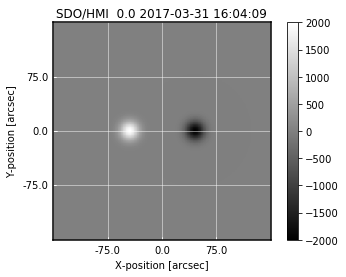

In [79]:
synthetic_hmi_map.peek()

Now, save the magnetogram to a FITS file.

In [81]:
synthetic_hmi_map.save('/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/synthetic_hmi_map.fits')

## Extrapolate Field
Now, extrapolate a magnetic field from our synthetic HMI map and trace an appropriate number of field lines.

In [82]:
zshape=100
zrange=u.Quantity([0,300]*u.arcsec)

In [83]:
field = synthesizAR.Skeleton(hmi_fits_file='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/synthetic_hmi_map.fits',
                             resample=u.Quantity([100,100]*u.pixel))

In [84]:
field.extrapolate_field(zshape,zrange)

True


yt : [INFO     ] 2017-03-31 16:05:47,258 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-31 16:05:47,259 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-03-31 16:05:47,261 Parameters: domain_left_edge          = [ -1.02667285e+10  -1.02667285e+10   4.33805429e+08]
yt : [INFO     ] 2017-03-31 16:05:47,262 Parameters: domain_right_edge         = [  1.07728348e+10   1.07728348e+10   2.12564660e+10]
yt : [INFO     ] 2017-03-31 16:05:47,263 Parameters: cosmological_simulation   = 0.0


In [85]:
field.extract_streamlines(500,loop_length_range=[1e9,1e11]*u.cm)

yt : [INFO     ] 2017-03-31 16:06:09,256 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 347.66it/s]
yt : [INFO     ] 2017-03-31 16:06:11,454 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 97/97 [00:00<00:00, 318.73it/s]
yt : [INFO     ] 2017-03-31 16:06:12,142 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 21/21 [00:00<00:00, 285.48it/s]
yt : [INFO     ] 2017-03-31 16:06:12,533 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 5/5 [00:00<00:00, 129.53it/s]
yt : [INFO     ] 2017-03-31 16:06:12,867 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 4/4 [00:00<00:00, 145.71it/s]
yt : [INFO     ] 2017-03-31 16:06:13,191 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


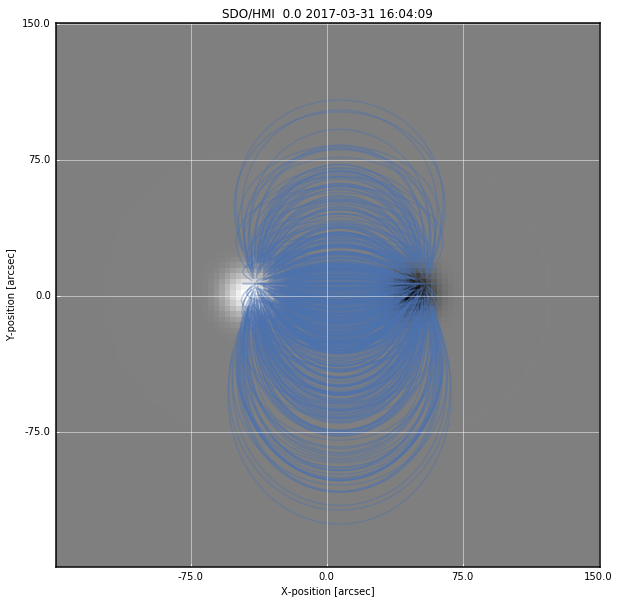

In [93]:
field.peek(alpha=0.4)

In [87]:
field.make_loops()

(array([ 124.,  104.,   65.,   53.,   45.,   29.,   20.,   18.,   17.,   25.]),
 array([  3.36150638e+09,   5.10747193e+09,   6.85343748e+09,
          8.59940303e+09,   1.03453686e+10,   1.20913341e+10,
          1.38372997e+10,   1.55832652e+10,   1.73292308e+10,
          1.90751963e+10,   2.08211619e+10]),
 <a list of 10 Patch objects>)

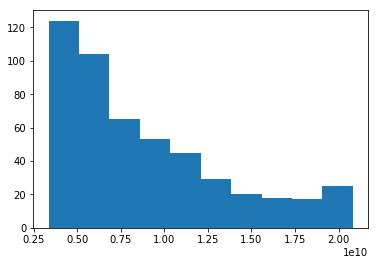

In [90]:
plt.hist([l.full_length.value for l in field.loops])

## Configure Heating Model and Loop Simulations
Setup a slightly modified nanoflare model that inherits from the usual scaled power-law model.

In [96]:
class NanoflareTrain(PowerLawScaledWaitingTimes):
    
    def _calculate_start_times(self,rates):
        scaling_constant = self._calculate_scaling_constant(rates)
        time_start_rise = np.empty([self.number_events])
        wait_time_sum = 0.0
        for i in range(self.number_events):
            wait_time_sum += ((rates[i]**(1.0/self.heating_options['waiting_time_scaling']))
                              / scaling_constant)
            time_start_rise[i] = i*self.heating_options['duration'] + wait_time_sum
        
        return time_start_rise

Set some heating parameters. We'll use an intermediate waiting time of 2500 s.

In [95]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'average_waiting_time':2500.0,
    'waiting_time_scaling':1.0
}

In [97]:
heating_model = NanoflareTrain(heating_options)

Setup the base configuration for all of the simulations.

In [98]:
ih = synthesizAR.util.InputHandler(os.path.join('/home/wtb2/Documents/codes',
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-6
base_config['adaptive_solver_safety'] = 0.5
base_config['total_time'] = 11000.0
base_config['use_flux_limiting'] = True
base_config['heating']['background'] = 1e-6
base_config['heating']['partition'] = 1.0

Now, configure all of the loop simulations. We'll run these simulations using EBTEL.

In [99]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                            '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/hydro_config/',
                            '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/hydro_results/')

In [100]:
field.configure_loop_simulations(ebtel_interface)

Power-law constrainer reached max # of tries, using best guess with error = 0.0014514253944123423
Power-law constrainer reached max # of tries, using best guess with error = 0.0012767226499585949
Power-law constrainer reached max # of tries, using best guess with error = 0.0022300215855617367
Power-law constrainer reached max # of tries, using best guess with error = 0.001417741696376984
Power-law constrainer reached max # of tries, using best guess with error = 0.0010625180180672267
Power-law constrainer reached max # of tries, using best guess with error = 0.00241448912729747
Power-law constrainer reached max # of tries, using best guess with error = 0.001297565805277845
Power-law constrainer reached max # of tries, using best guess with error = 0.0010191672513961691
Power-law constrainer reached max # of tries, using best guess with error = 0.0012042156353129219
Power-law constrainer reached max # of tries, using best guess with error = 0.0015027284416009312
Power-law constrainer re

## Run Loop Simulations
Finally, run all of the loop simulations, load in the results, and save the field.

In [102]:
for loop in field.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [103]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/loop_parameters.h5')

In [104]:
field.save(savedir='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/field_checkpoint')

(0, 11000.0)

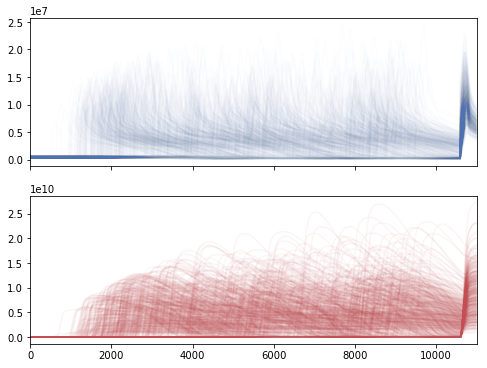

In [107]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)
for loop in field.loops:
    axes[0].plot(loop.time,loop.temperature[:,0],
                 color=sns.color_palette('deep')[0],
                 alpha=0.01)
    axes[1].plot(loop.time,loop.density[:,0],
                 color=sns.color_palette('deep')[2],
                 alpha=0.05)
axes[0].set_xlim([0,1.1e4])